# HW02 (due October 10th, 23:59)

In this homework you will investigate the *causal* of being part of a union on the number of hours worked. You will work with data from the National Longitudinal Survey. In particular, you have a panel of young women who were between 14 and 26 years of age in 1968, surveyed for 20 years.

The purpose of this homework is ot make you think about the **identification** assumptions underlying your empirical strategy, namely the assumptions that allow the coefficient estimate from the regressions to be causal. Throughout the homework you will try to address the issue of **omitted variable bias** through different strategies, that will allow to make milder identification assumptions.

# Load Data

In [1]:
##Load the NLSY dataset
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

data = pd.read_stata('https://www.stata-press.com/data/r16/nlswork.dta')

In [2]:
pd.read_stata('https://www.stata-press.com/data/r16/nlswork.dta', iterator=True).variable_labels()

{'idcode': 'NLS ID',
 'year': 'interview year',
 'birth_yr': 'birth year',
 'age': 'age in current year',
 'race': 'race',
 'msp': '1 if married, spouse present',
 'nev_mar': '1 if never married',
 'grade': 'current grade completed',
 'collgrad': '1 if college graduate',
 'not_smsa': '1 if not SMSA',
 'c_city': '1 if central city',
 'south': '1 if south',
 'ind_code': 'industry of employment',
 'occ_code': 'occupation',
 'union': '1 if union',
 'wks_ue': 'weeks unemployed last year',
 'ttl_exp': 'total work experience',
 'tenure': 'job tenure, in years',
 'hours': 'usual hours worked',
 'wks_work': 'weeks worked last year',
 'ln_wage': 'ln(wage/GNP deflator)'}

#  Summary statistics

Inspect the data.

/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_7719/3374572931.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bar_data = data.groupby(['hours_range', 'union']).size().unstack(fill_value=0)


<Axes: xlabel='hours_range'>

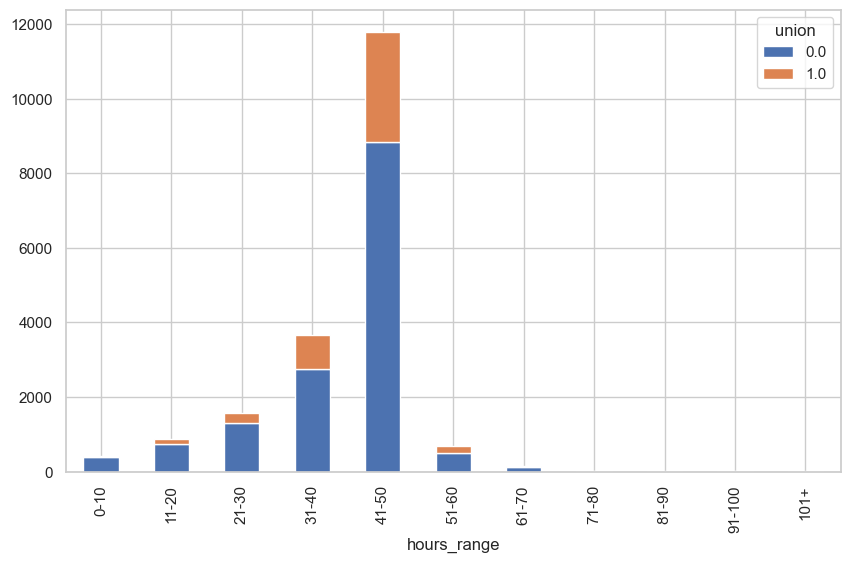

In [11]:
##Visualize the dataset

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]  # Define the bins for hours worked
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60','61-70', '71-80', '81-90', '91-100', '101+']  # Labels for the bins

# Create a new column 'hours_range' that specifies the range for each row
data['hours_range'] = pd.cut(data['hours'], bins=bins, labels=labels, right=False)
bar_data = data.groupby(['hours_range', 'union']).size().unstack(fill_value=0)

bar_data.plot(kind='bar', stacked=True, figsize=(10, 6))


In [12]:
##tabulate college and union status 
pd.crosstab(data['collgrad'], data['union'], rownames=['collgrad'], colnames=['union'], normalize='index')

union,0.0,1.0
collgrad,,
0,0.779522,0.220478
1,0.708089,0.291911


In [13]:
##generate a variable for log hours worked
logHours = np.log(data['hours'])

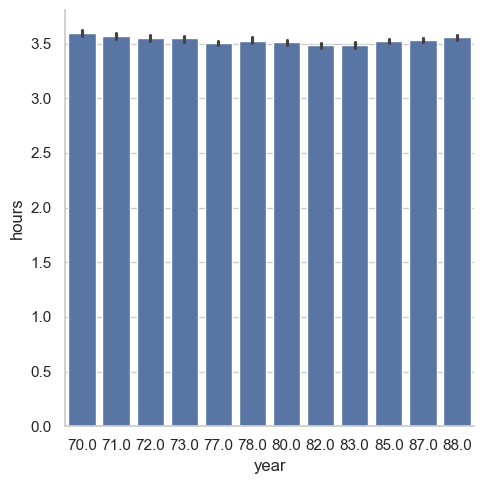

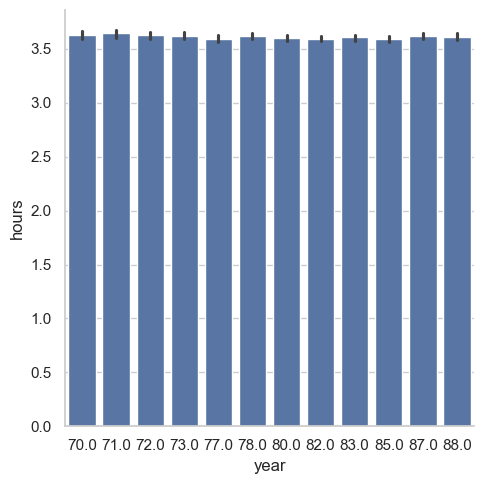

In [14]:
##plot log hours against year separately for union and non-union
import seaborn as sns

sns.set(style="whitegrid")

# Create separate bar plots for union status 0 and 1
sns.catplot(x='year', y=logHours, data=data[data['union'] == 0], kind='bar')
sns.catplot(x='year', y=logHours, data=data[data['union'] == 1], kind='bar')

# Regression: Effect of union status on hours worked

In [15]:
##Regress hours worked against union status and display the results
formula = 'hours ~ union'
res = smf.ols(formula=formula, data=data.dropna(subset=['union','hours'])).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  hours   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     136.6
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           1.85e-31
Time:                        17:18:31   Log-Likelihood:                -70568.
No. Observations:               19202   AIC:                         1.411e+05
Df Residuals:                   19200   BIC:                         1.412e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3112      0.079    461.166      0.0

In [16]:
##Print or write out the coefficient on union, standard error, t-stat, p-value and confidence interval
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3112      0.079    461.166      0.000      36.157      36.466
union          1.9006      0.163     11.689      0.000       1.582       2.219


#### What is the identification assumption for the coefficient on union to be causal?

For the coefficient on union to be causal, the identification assumption is that no variables that impact hours worked are left out of the regression. So, all confounders would need to be controlled. 




In [17]:
## add education (collgrad) to the regression and compare the coefficient on union with the previous result
processedData = data
processedData.dropna(subset=['union','hours','collgrad'],inplace=True)

formula = 'hours ~ union + collgrad'
res = smf.ols(formula=formula, data=processedData).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.9239      0.084    425.314      0.000      35.758      36.089
union          1.7661      0.162     10.880      0.000       1.448       2.084
collgrad       2.1420      0.173     12.353      0.000       1.802       2.482


In [18]:
## add occupation codes to the regression and compare the results with the previous one
processedData = data
processedData.dropna(subset=['union','hours','collgrad','occ_code'],inplace=True)

formula = 'hours ~ union + collgrad + occ_code'
res = smf.ols(formula=formula, data=processedData).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3363      0.125    291.500      0.000      36.092      36.581
union          1.8860      0.165     11.426      0.000       1.562       2.210
collgrad       2.2569      0.176     12.853      0.000       1.913       2.601
occ_code      -0.0982      0.022     -4.420      0.000      -0.142      -0.055


#### In terms of causal inference, why is adding occupation code as a control probably not a good idea?

Adding occupation code is a bad idea because your occupation is also related to whether you graduated from college, in addition to whether you are in a union or how many hours you work. For example, blue collar workers are less likely to have gone to college and more likely to be in a union. So, some of the independent variables may be closely related in this case.


#### What are "good controls" in the dataset in terms of being exogenous to union status?

Good controls are variables such as age and nev_married (marital status). These are less likely to be related to being in a union.


In [19]:
##add these controls to the regression
processedData = data
processedData.dropna(subset=['union','hours','age','nev_mar'],inplace=True)

formula = 'hours ~ union + age + nev_mar'
res = smf.ols(formula=formula, data=processedData).fit()
print(res.summary().tables[1])


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.2057      0.380     95.390      0.000      35.462      36.950
union          1.8424      0.162     11.380      0.000       1.525       2.160
age           -0.0135      0.012     -1.167      0.243      -0.036       0.009
nev_mar        2.8004      0.181     15.511      0.000       2.447       3.154


#### How do these change your estimates?


Changing the independent variables to union, age, and nev_mar have changed the results of the variables regarding 'union.' The results changed from 

Before:

Intercept

<ul>
<li>coef: 36.3363</li>     
<li>std err: 0.125</li>     
<li>t: 291.500</li>        
<li>p: 0.000</li>        
<li>[0.025]: 36.092</li>        
<li>[0.975]: 36.581</li>  
</ul>

Union

<ul>
<li>coef: 1.8860</li>       
<li>std err: 0.165</li>      
<li>t: 11.426</li>       
<li>p: 0.000</li>        
<li>[0.025]: 1.562</li>        
<li>[0.975]: 2.210</li>  
</ul>

to 

Intercept

<ul>
<li>coef: 36.2057</li>    
<li>std err: 36.2057</li>    
<li>t: 95.390</li>     
<li>p: 0.000</li>      
<li>[0.025]: 35.462</li>     
<li>[0.975]: 36.950</li>
</ul>

Union

<ul>
<li>coef: 1.8424</li>    
<li>std err: 0.162</li>    
<li>t: 11.380</li>    
<li>p: 0.000</li>      
<li>[0.025]: 1.525</li>      
<li>[0.975]: 2.160</li>
</ul>


Showing that the results did change slightly based on the independent variables used. So, removing the variables that could be impacting both the independent and dependent variables may have led to a more accurate answer.


# Short Essay: Correlation/Causation

**Find a news article mistaking correlation for causation. Link to the article and write a short paragraph explaining the mistake.**

[type your comments here, or attach as separate document.]

https://www.cbsnews.com/news/school-vending-machine-laws-would-help-kids-lose-weight-study-shows/

This article talks about how schools with vending machines generally have heavier students. A study establishes this well, however, the article also makes a claim that removing the vending machines will help students lose weight. This is confusing correlation with causation because even though the two appear to be linked, the study didn't establish that the vending machines cause the weight gain. And even more so, the study didn't conclusively find that removing vending machines would lead to students losing weight. Interestingly enough, someone challenged this claim and in a new study, found that students moving to a school without vending machines did not lead to a decrease in weight. This could be due to confounding variables that impact weight such as food availability in the town that leads to installing vending machines in the school.